### Python Implementação Regressão Linear 


In [1]:
# todos os imports que vou utilizar
import numpy as np
import matplotlib.pyplot as plt

### Implementação de uma Classe Abstrata Modelo RL
Essa classe vai servir de base pros outros modelos que vou criar, sendo eles:
- Gradiente Descendente
- Gradiente Descendente Estocástico
- OLS (Ordinary Least Square)

In [2]:
class Scaler():
    def __init__(self, columnNumber = 2):
        self.__means = np.empty(columnNumber)
        self.__stds = np.empty(columnNumber)
        self.__quantity = 0
        
    def __setMeans(self, newMeans):
        self.__means = newMeans
    
    def getMeans(self):
        return self.__means
    
    def __setStds(self, newStds):
        self.__stds = newStds
    
    def getStds(self):
        return self.__stds
    
    def __setQuantity(self, newQ):
        self.__quantity = newQ
    
    def getQuantity(self):
        return self.__quantity
    
    def __addValues(self, mu, sigma):
        means = self.getMeans()
        stds = self.getStds()
        quantity = self.getQuantity()
        
        means[quantity] = mu
        stds[quantity] = sigma
        
        self.__setMeans(means)
        self.__setStds(stds)
        
        self.__setQuantity(quantity + 1)
    
    def scale(self, data):
        rows = data.shape[0]
        columns = data.shape[1]
        #Utiliza a Normalização Z-score, seria o equivalente ao Standard Scaler
        #Recebe um conjunto de dados e Retorna o mesmo conjunto de dados normalizado com média 0 e dp 1
        dataScaled = np.empty([rows, 0])
        for i in range(columns):
            #Esse método faz a normalização coluna por coluna, onde i é o número da coluna
            dataColumn = data[:, [i]]

            #Cálculo da média e desvio-padrão da coluna que vai ser normalizada
            mu = np.mean(dataColumn)
            sigma = np.std(dataColumn)

            columnScaled = (dataColumn - mu)/sigma
            #columnScaled = (xi - mu)/sigma
            #operação broadcasting para toda a coluna
            dataScaled = np.c_[dataScaled, columnScaled]
            
            self.__addValues(mu, sigma)
            #adiciona a coluna no dataset normalizado
        #print(dataScaled)
        return dataScaled
    
    def unscale(self, data, column = -1):
        # pensando em implementar um atributo dataset original
        # mas esse método tem como função principal fazer o "unscale" de novos atributos de um dado escalado
        # anteriormente, como por exemplo ŷ que é escalado na normal com base nos dados de y
        if column == -1:
            mu = self.getMeans()
            sigma = self.getStds()
            
        elif column >= self.getQuantity():
            print("ERRO: Número de Coluna ", column ," Inválida.")
            
        else:
            mu = self.getMeans()[column]
            sigma = self.getStds()[column]
            
        return sigma * data + mu

In [43]:
from abc import ABC, abstractmethod

class LinearRegression(ABC):
    def __init__(self, xSize = 1, weights = []):
        #xSize representa o número de colunas que vai ser usado nessa regressão linear como X
        #se será uma simples, teremos xSize com valor igual a 1, que é a base
        #mais que isso o usuário deve informar
        self.__xSize = xSize
        if weights == []:
            self.__weights = np.zeros(xSize + 1)
        elif xSize == weights.shape[0] - 1:
            self.__weights = np.array(weights)
        else:
            print("ERRO: Vetor peso inicial de tamanho ", xSize, " enquanto o número de multiplicadores é ", weights.shape[0] - 1)
            return
        
    def setxSize(self, newXs):
        self.xSize = newXs
    
    def getXsize(self):
        return self.__xSize
        
    def setWeights(self, newW):
        self.__weights = newW
    
    def getWeights(self):
        return self.__weights
            
    def train(self, X, Y, l2 = 0):
        pass
    def test(self, X):
        #aqui eu to passando o tipo de erro mas ainda to decidindo se vou manter isso ou não
        pass
    def polinomial(self, data, graus):
        Y = data[:, data.shape[1] - 1]
        data = data[:, :data.shape[1] - 1]
        newdata = data.copy()
        #um método para tornar uma regressão linear em polinomial
        for grau in range(2,graus +1):
            #não mexe no Y
            for colunaN in range(data.shape[1]):
                coluna = data[:, colunaN]
                novaColuna = coluna ** grau
                newdata = np.c_[newdata, novaColuna]
                #print(coluna, grau)
        data = np.c_[newdata, Y]
        #print(data)
        self.setxSize(self.getxSize() * graus)
        w = np.zeros((self.getWeights().shape[0] - 1) * graus + 1)
        self.setWeights(w)
        #print(w)
        return data
    def calcErro(self, Y_hat, Y, N):
        resultados = np.sqrt(((Y_hat - Y)**2).sum()/N)
        return resultados

class OrdinaryLeastSquare(LinearRegression):

    def __init__(self, xSize = 1, weights = []):
        super().__init__(xSize, weights)
        
    def setxSize(self, newXs):
        self._LinearRegression__xSize = newXs
    
    def getxSize(self):
        return self._LinearRegression__xSize
        
    def setWeights(self, newW):
        self._LinearRegression__weights = newW
    
    def getWeights(self):
        return self._LinearRegression__weights
    
    def train(self, X, Y, l2 = 0):
        #X = np.array(X)
        #Y = np.array(Y)
        if X.shape[1] != (self.getWeights()).shape[0] - 1:
            print("ERRO: tamanho de X ", X.shape[1] ,"não condiz com a quantidade de pesos multiplicadores ", self.getWeights().shape[0] - 1)
            return
        if Y.shape[1] != 1:
            print("ERRO: tamanho de Y maior diferente do que 1, essa é uma regressão univariada, utilize apenas Y size = 1")
            return
        I = np.eye(self.getXsize())
        moorePenroseMatrix = np.linalg.inv(X.T @ X + l2 * I) @ X.T
        
        # o OLS utiliza o peso como [[w1], [w2]] por exemplo
        # mas para manter o padrão de peso que vou usar em todas as RLs como [w0, w1, w2] eu faço essa mudancinha
        newW = (moorePenroseMatrix @ Y).flatten()
        newW = np.insert(newW, 0, 0)
        self.setWeights(newW)
    # vou pensar ainda se vou calcular o erro em test mesmo ou se vou mudar
    def test(self, X):
        # esse W, pega os pesos na forma de [w0, w1, w2, w3] ignora o w0 pega o resto e faz
        # ficar [[w1], [w2], [w3]] para ser utilizado no OLS
        #print(self.getWeights().shape[0])
        W = self.getWeights()[1:].reshape([self.getWeights().shape[0] - 1,1])
        Yhat = X @ W
        #print(W)
        #print(self.getWeights())
        #Yhat = sigma * Yhat + mu
        #Y = sigma * Y + mu
        #MSE = (Yhat - Y) ** 2
        #print("testando: ",Yhat)
        
        return Yhat

In [4]:
class GradientDescent(LinearRegression):

    def __init__(self, xSize = 1, weights = []):
        super().__init__(xSize, weights)
        
    def setxSize(self, newXs):
        self._LinearRegression__xSize = newXs
    
    def getxSize(self):
        return self._LinearRegression__xSize
        
    def setWeights(self, newW):
        self._LinearRegression__weights = newW
    
    def getWeights(self):
        return self._LinearRegression__weights
    
    def train(self, X, Y, alpha = 0.1, weights = [], numberofIterations = 200, l2 = 0):
        if weights == []:
            weights = self.getWeights() + 0.5
        X = np.c_[np.ones([X.shape[0]]), X]
        N = X.shape[0]
        # adicionando uma coluna de 1's na coluna0 de X
        # posso mudar esse for para ser uma condição enviada em forma de lambda func dps
        for T in range(0, numberofIterations):
            Ypredict = np.empty([0])
            #criando as "predições" que serão utilizadas para melhor o W
            e = np.empty([0])
            for i in range(N): # esse for é para gerar os yi's, calculando eles linha por linha
                temporaryY = (weights * X[i, :]).sum() # somando w0 + w1 * x1 + ... + wn * xn
                Ypredict = np.insert(Ypredict, Ypredict.shape[0], temporaryY) # adicionando o Yp no lugar certo
            Ypredict = Ypredict.reshape(-1,1) # mudando o shape dele de [1,2,3] para [[1], [2], [3]]
            e = Y - Ypredict # calculando o e = (y - ŷ)
            # separa o 0 por causa do termo de regularização
            weights[0] = weights[0] + (alpha/N * np.sum(e * X[:, [0]]))
            for index in range(1, weights.shape[0]):
                weights[index] = weights[index] + (alpha/N * np.sum(e * X[:, [index]]) - l2 * weights[index])
                # recalculando os pesos
        self.setWeights(weights)
            
    def test(self, X):
        X = np.c_[np.ones([X.shape[0]]), X]
        weights = self.getWeights()
        Ypredict = np.empty([0])
        for i in range(X.shape[0]):
            Ypredict = np.insert(Ypredict, Ypredict.shape[0],(X[i, :] * weights).sum())
        Ypredict = Ypredict.reshape(-1,1)
        #print(Ypredict)
        return Ypredict

In [40]:
class StochasticGradientDescent(LinearRegression):
    def __init__(self, xSize = 1, weights = []):
        super().__init__(xSize, weights)
        
    def setxSize(self, newXs):
        self._LinearRegression__xSize = newXs
    
    def getxSize(self):
        return self._LinearRegression__xSize
        
    def setWeights(self, newW):
        self._LinearRegression__weights = newW
    
    def getWeights(self):
        return self._LinearRegression__weights
    
    def train(self, X, Y, alpha = 0.1, weights = [], numberofIterations = 200, l2 = 0):
        if weights == []:
            weights = self.getWeights() + 0.5
        X = np.c_[np.ones([X.shape[0]]), X]
        Ypredict = -1
        #criando as "predições" que serão utilizadas para melhor o W
        e = -1
        for i in range(numberofIterations):
            randomLine = np.random.randint(0, X.shape[0])
            #no estocastico invés de pegarmos todos os X e depois fazer a média nós pegamos apenas um X aleatório
            #print("Y = ", weights, " * ", X[randomLine])
            Ypredict = (weights * X[randomLine]).sum()
            #print("Resultado: ", Ypredict)
            e = Y[randomLine] - Ypredict
            weights[0] = weights[0] + alpha *( (e * X[[randomLine], [0]]))
            for index in range(1, weights.shape[0]):
                #print("Valor Sorteado: ", randomLine, "/n", "W = ", weights[index] ,' + ',alpha, " * ", e, " * ", X[[randomLine], [index]])
                # wi = wi + alpha * (e * xi)
                weights[index] = weights[index] + alpha *( (e * X[[randomLine], [index]]) - l2 * weights[index] )
        self.setWeights(weights)
            
    def test(self, X):
        #teste padrão
        X = np.c_[np.ones([X.shape[0]]), X]
        weights = self.getWeights()
        Ypredict = np.empty([0])
        for i in range(X.shape[0]):
            Ypredict = np.insert(Ypredict, Ypredict.shape[0],(X[i, :] * weights).sum())
        Ypredict = Ypredict.reshape(-1,1)
        #print(Ypredict)
        return Ypredict
    
    

In [6]:
# lendo um txt como uma matriz

dataset = np.genfromtxt('artificial1d.csv', delimiter=',')

dataset2 = np.genfromtxt('california.csv', delimiter=',')

print('tes')


tes


In [7]:
def questao1(data):
    X = data[:, [0]]
    Y = data[:, [1]]
    
    retaX = np.linspace(-1, 1, 100)
    
    resultados = np.array([-1,-1,-1], dtype = np.double)
    
    fig, axes = plt.subplots(figsize = (7, 16), nrows = 3)
    
    GD = GradientDescent()
    SGD = StochasticGradientDescent()
    OLS = OrdinaryLeastSquare()
    
    GD.train(X, Y, numberofIterations = 200)
    SGD.train(X, Y, numberofIterations = 200)
    OLS.train(X, Y)
    
    predicao = GD.test(X)
    resultados[0] = np.sqrt(((predicao - Y)**2).sum()/X.shape[0])
    
    predicao = SGD.test(X)
    resultados[1] = np.sqrt(((predicao - Y)**2).sum()/X.shape[0])
    
    predicao = OLS.test(X)
    resultados[2] = np.sqrt(((predicao - Y)**2).sum()/X.shape[0])
    
    fig.tight_layout(pad = 5)

    axes[0].plot(X, Y, "ro")
    axes[0].set_title(("Gradiente Descendente.\nMSE = " + str(round(resultados[0], 6))))
    W = GD.getWeights()
    retaY = retaX * W[1] + W[0] 
    axes[0].plot(retaX, retaY, 'b-')
    
    axes[1].plot(X, Y, "ro")
    axes[1].set_title(("Gradiente Descendente Estocástico.\nMSE = " + str(round(resultados[1], 6))))
    W = SGD.getWeights()
    retaY = retaX * W[1] + W[0]
    axes[1].plot(retaX, retaY, 'b-')
    
    axes[2].plot(X, Y, "ro")
    axes[2].set_title(("Mínimos Quadrados Ordinários(OLS).\nMSE = " + str(round(resultados[2], 6))))
    W = OLS.getWeights()
    retaY = retaX * W[1] + W[0]
    axes[2].plot(retaX, retaY, 'b-')
    
    fig.savefig(".//Gráficos//plotQ1.png")


In [24]:
def dividirTreinoTeste(data, percentOfTrain):
    np.random.seed(42)
    indices = np.random.permutation(len(data))
    
    #dividindo em treino e teste
    indicesTreino = indices[:int(len(data)*percentOfTrain)]
    indicesTeste = indices[int(len(data)*percentOfTrain):]
    
    treino = data[indicesTreino,:]
    teste = data[indicesTeste,:]
    
    return treino, teste
    

def teste(data):
    data = np.array(data)
    data2 = np.array(data)
    data3 = np.array(data)
    
    GD = GradientDescent()
    GD2 = GradientDescent()
    OLS = OrdinaryLeastSquare()
    
    data = GD.polinomial(data, 13)
    data2 = GD2.polinomial(data2, 13)
    data3 = OLS.polinomial(data3, 13)
    
    treino, teste = dividirTreinoTeste(data, 1.0)
    
    #dividindo x e y
    xtreino = data[:, :treino.shape[1] - 1]
    xteste = teste[:, :teste.shape[1] - 1]
    
    ytreino = data[:, [treino.shape[1] - 1]]
    yteste = teste[:, [teste.shape[1] - 1]]
    
    GD2.train(xtreino, ytreino, alpha = 0.9 ,numberofIterations = 2000)
    GD.train(xtreino, ytreino, alpha = 0.9 ,numberofIterations = 2000, l2 = 0.15)
    OLS.train(xtreino, ytreino, l2 = 0.15)
    
    #pred = GD.test(xteste)
    #print(GD.getWeights())
    
    #resultados = np.sqrt(((pred - yteste)**2).sum()/teste.shape[0])
    
    retaX = np.linspace(-1, 1, 100)    
    retaY = np.zeros(100)
    retaY2 = np.zeros(100)
    retaY3 = np.zeros(100)
    
    for i in range(14):
        retaY += retaX ** i * GD.getWeights()[i]
        retaY2 += retaX ** i * GD2.getWeights()[i]
        retaY3 += retaX ** i * OLS.getWeights()[i]
    plt.plot(xtreino[:, 0], ytreino, 'ro')
    plt.plot(retaX, retaY, 'b-')
    plt.plot(retaX, retaY2, 'g-')
    plt.plot(retaX, retaY3, 'y-')
    print(GD.getWeights())
    print(GD2.getWeights())
    print(OLS.getWeights())
    plt.show()
    
    #print(resultados)


In [144]:
def questao2(data):
    data = np.array(data)
    valores = []
    
    for i in range(1, 14):
        normalizer = Scaler(8 * i + 1)        
        OLS = OrdinaryLeastSquare(8)
        
        
        data2 = OLS.polinomial(data, i)
        dataPolinomial = normalizer.scale(data2)
        treino, teste = dividirTreinoTeste(dataPolinomial, 0.8)
        
        #dividindo x e y
        xtreino = treino[:, :treino.shape[1] - 1]
        xteste = teste[:, :teste.shape[1] - 1]    

        ytreino = treino[:, [treino.shape[1] - 1]]
        yteste = teste[:, [teste.shape[1] - 1]]

        OLS.train(xtreino, ytreino, l2 = 0.1)

        pred = OLS.test(xteste)

        #como predicao equivale ao Y, e o Y é a coluna numero 8 do dataset original, nosso normalizer guarda 
        #a media e o dp dela na posicao 8, só precisamos informar isso
        pred = normalizer.unscale(pred, teste.shape[1] - 1)
        yteste = normalizer.unscale(yteste, teste.shape[1] - 1)

        valores.append(calcMSE(pred, yteste, 200))
    print(valores)
    plt.plot(valores)


[0.6533816643439424, 0.7271267015631284, 0.6571142323846672, 0.6486336699507016, 0.6528984697951506, 0.6529396726005456, 0.6499080037918614, 0.649422435549434, 0.652879204745127, 0.6577473976097207, 0.6609679444845669, 0.6614204908252406, 0.6598894406515232]


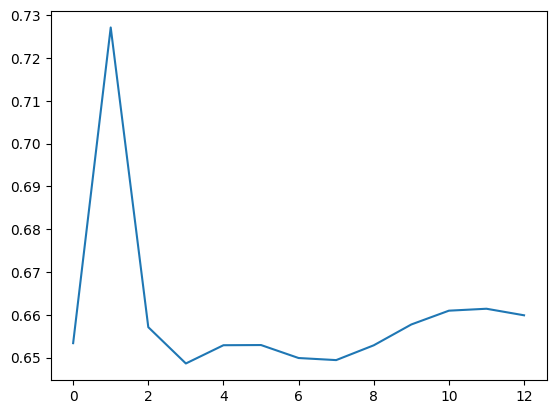

In [145]:
#falta só rodar o loop
questao2(dataset2)
# maior alfa mais overfitting ele dá
# preciso implementar regressão polinomial para questão 2

In [11]:
print('a')

a
